In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from copy import deepcopy

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from torch.utils.data import DataLoader
import torch

from sklearn.metrics import accuracy_score

In [30]:
df = pd.read_csv("/content/mental_health.csv")


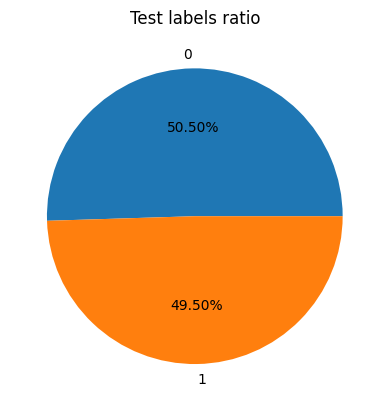

In [31]:
main, test = train_test_split(df, random_state=42, test_size=0.01)
freqs = main['label'].value_counts()
plt.pie(freqs, labels=freqs.index, autopct="%0.2f%%")
plt.title("Test labels ratio")
plt.show()

In [32]:
train, val = train_test_split(main.values, random_state=42, test_size=0.2)


In [33]:
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for text, label in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train), specials=["<unk>"])
vocab.set_default_index(vocab['<unk>'])

In [34]:
text_pipeline = lambda x: vocab(tokenizer(x))


In [35]:
VOCAB_SIZE=len(vocab)
NUM_CLASSES = 2
EM_SIZE=32
BATCH = 32
EPOCHS = 33
STEP = 5
GAMMA = 0.1
LR = 0.1

In [36]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _text, _label in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return text_list, label_list, offsets

train_loader = DataLoader(train, batch_size=BATCH, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val, batch_size=BATCH, shuffle=False, collate_fn=collate_batch)

In [37]:
class TextClassifier(torch.nn.Module):
    def __init__(self, vocab_size, em_size, num_classes):
        super(TextClassifier, self).__init__()
        self.embed = torch.nn.EmbeddingBag(vocab_size, em_size, sparse=False)
        self.layers = torch.nn.Sequential(torch.nn.Linear(32, 128),
                                          torch.nn.ReLU(),
                                          torch.nn.Dropout1d(),
                                          torch.nn.BatchNorm1d(128),
                                         torch.nn.Linear(128, 256),
                                          torch.nn.ReLU(),
                                          torch.nn.Dropout1d(),
                                          torch.nn.BatchNorm1d(256),
                                         torch.nn.Linear(256, 256),
                                          torch.nn.ReLU(),
                                         torch.nn.Dropout1d(),
                                          torch.nn.BatchNorm1d(256))
        self.fc = torch.nn.Linear(256, num_classes)

    def forward(self, x, offset):
        x = self.embed(x, offset)
        x = self.layers(x)
        return x


In [38]:
model = TextClassifier(VOCAB_SIZE, EM_SIZE, NUM_CLASSES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [39]:
best_model = deepcopy(model)
best_acc = 0

train_history = []
val_history = []
acc_history = []

al_start = time.time()

for i in range(1, EPOCHS+1):
    start = time.time()
    model.train()
    train_loss = 0
    train_total = 0

    for idx, (text, label, offset) in enumerate(train_loader):
        optimizer.zero_grad()

        if torch.cuda.is_available():
            text, label, offset = text.cuda(), label.cuda(), offset.cuda()

        out = model(text, offset)
        loss = criterion(out, label)
        train_loss += loss.item()
        train_total += out.size(0)

        loss.backward()
        optimizer.step()

    val_loss = 0
    val_total = 0
    acc = 0

    model.eval()

    with torch.no_grad():
        for idx, (text, label, offset) in enumerate(val_loader):
            if torch.cuda.is_available():
                text, label, offset = text.cuda(), label.cuda(), offset.cuda()

            out = model(text, offset)
            loss = criterion(out, label)
            acc += (out.argmax(1) == label).sum().item()
            val_loss += loss.item()
            val_total += out.size(0)

    end = time.time()
    accuracy = acc/val_total

    train_history += [train_loss/train_total]
    val_history += [val_loss/val_total]
    acc_history += [accuracy]

    if accuracy>best_acc:
        best_acc = accuracy
        best_model = deepcopy(model)

    scheduler.step()


    print("Epoch {} || train_loss: {} || val_loss: {} || acc: {} || time: {}".format(i,
                                                                                    train_loss/train_total,
                                                                                    val_loss/val_total,
                                                                                    accuracy,
                                                                                    end-start))

al_end = time.time()
print("Total time ", al_end-al_start)


Epoch 1 || train_loss: 0.02467564001094995 || val_loss: 0.020208968711674 || acc: 0.6270758122743683 || time: 21.54292106628418
Epoch 2 || train_loss: 0.020813533100038303 || val_loss: 0.020169298011903727 || acc: 0.5604693140794224 || time: 20.6813383102417
Epoch 3 || train_loss: 0.0206412028689599 || val_loss: 0.018379222711931497 || acc: 0.7866425992779783 || time: 23.24252438545227
Epoch 4 || train_loss: 0.0206054287917262 || val_loss: 0.019474285227727373 || acc: 0.785740072202166 || time: 29.101974487304688
Epoch 5 || train_loss: 0.020586076815022766 || val_loss: 0.01826098652738096 || acc: 0.8963898916967509 || time: 29.50916886329651
Epoch 6 || train_loss: 0.020177772408622414 || val_loss: 0.01673819192480094 || acc: 0.8857400722021661 || time: 24.574536561965942
Epoch 7 || train_loss: 0.02002750884896394 || val_loss: 0.016786311012743183 || acc: 0.8962093862815884 || time: 24.445855855941772
Epoch 8 || train_loss: 0.019985698658824855 || val_loss: 0.017000434851603387 || acc: 

In [40]:
epochs = list(range(1, EPOCHS+1))


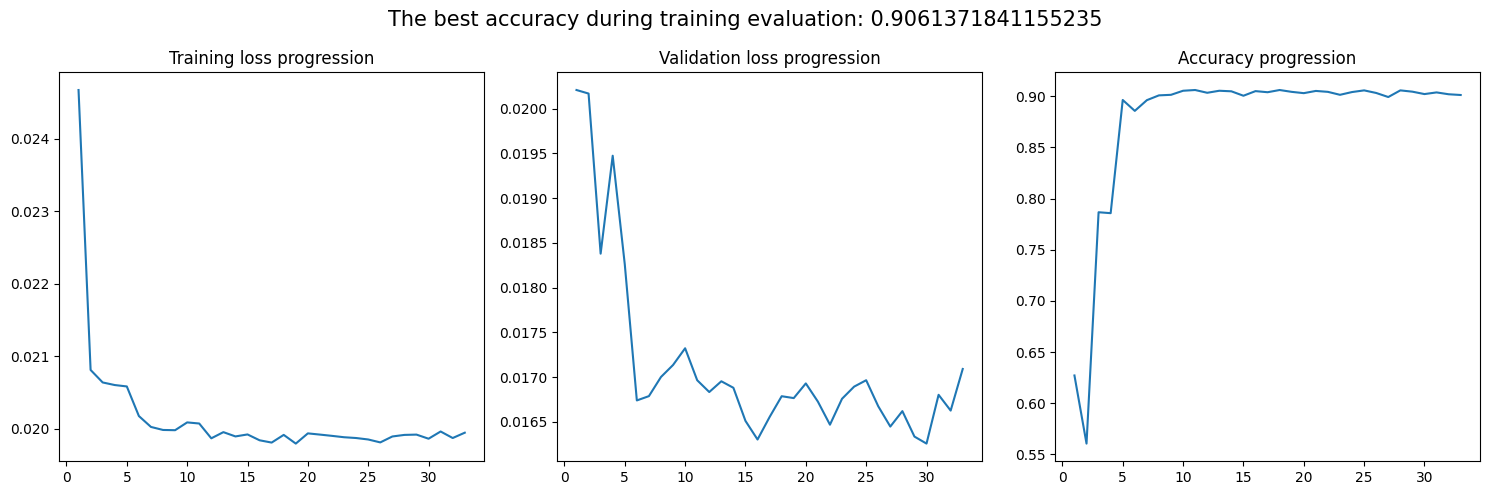

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].plot(epochs, train_history)
axes[1].plot(epochs, val_history)
axes[2].plot(epochs, acc_history)
axes[0].set_title("Training loss progression")
axes[1].set_title("Validation loss progression")
axes[2].set_title("Accuracy progression")
plt.suptitle("The best accuracy during training evaluation: {}".format(best_acc), size=15)
plt.tight_layout()
plt.show()

In [42]:
def predict(text):
    processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
    off = torch.tensor([0])
    best_model.eval()
    if torch.cuda.is_available():
        processed_text, off = processed_text.cuda(), off.cuda()
    out = best_model(processed_text, off)
    pred = out.argmax(1).cpu().detach().numpy()
    return pred[0]

In [43]:
predictions = [predict(x) for x in test['text'].values]
real = test['label'].values
accuracy_score(predictions, real)

0.9392857142857143

In [44]:
def predict_input():
    # Get user input
    user_input = input("Enter a text for prediction: ")

    # Make prediction using the predict function
    prediction = predict(user_input)

    # Display the prediction
    print("Prediction:", prediction)

# Call the function to predict user input
predict_input()


Enter a text for prediction: jfjhjfjfjhfjhfrytdgcffkhvnb
Prediction: 0
